In [46]:
import os
import numpy as np
from scipy import integrate
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24)

In [47]:
methods = ['rr_sb0.05', 'jpa', 'matrixeqtl']
whichplot = 'fpr_tpr'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'

In [48]:
simdir = '15158_450_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_20_0.02'
srcdir = '/scratch/sbanerj/trans-eqtl/simulation'

In [49]:
def zoomplot(ax, xx, yy, label, zoom = 1, yerr = None, color = None):
    nx = len(xx)
    nplot = int(nx * zoom)
    ax.plot(xx[:nplot], yy[:nplot], label = label, color = color)
    
    
def add_vert(fig, ax, hfrac, vfrac, hoffset, voffset):

    bbox = ax.get_position()
    axleft = bbox.x0
    axwidth = bbox.width
    axbottom = bbox.y0
    axheight = bbox.height

    iax_left   = axleft   + hoffset * axwidth
    iax_bottom = axbottom + voffset * axheight
    iax_width  = hfrac * axwidth
    iax_height = vfrac * axheight

    iax = fig.add_axes([iax_left, iax_bottom, iax_width, iax_height])
    return iax

def single_barplot(ax, yvals, ymax, yerr, methodcolors, errcolors, ymajorticks, yminorticks, yshift,
                   xlabel, ylabel, showyaxis, showxlabel, showerror):
    
    nbar = len(yvals)

    ax.set_yticks([y - yshift for y in ymajorticks])
    ax.set_yticks([y - yshift for y in yminorticks], minor=True)
    ax.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False, labelbottom = False)
    ax.grid(which = 'minor', axis = 'y', linestyle = 'dotted', zorder = 0)
    
    ind = np.arange(1, nbar + 1)
    ax.bar(ind, [y - yshift for y in yvals], color = methodcolors, linewidth = 0, width = 0.8, zorder = 10)
    
    # Errorbars done separately. The one included in bar() method mess up the zorder
    if showerror:
        for i in range(nbar):
            errmin = yvals[i] - yerr[i] - yshift
            errmax = yvals[i] + yerr[i] - yshift
            ax.plot([ind[i], ind[i]], [errmin, errmax], color = errcolors[i], zorder = 20)

    
    if showyaxis: 
        ax.tick_params(which = 'major', right = True, labelright = True)
        yticks = ax.get_yticks(minor = False)
        yticklabels = ['{:2.1f}'.format(y + yshift) for y in yticks]
        ax.set_yticklabels(yticklabels, minor = False)
        ax.set_ylabel(ylabel)
        ax.yaxis.set_label_position("right")
        
    if showxlabel:
        ax.set_xlabel(xlabel)
        
    for side, border in ax.spines.items():
        if not side == 'bottom':
            border.set_visible(False)
        if showyaxis and side == 'right':
            border.set_visible(True)

    ax.set_ylim([-0.01, ymax - yshift])
    ax.set_xlim([0, nbar + 1])
    ax.set_facecolor('None')

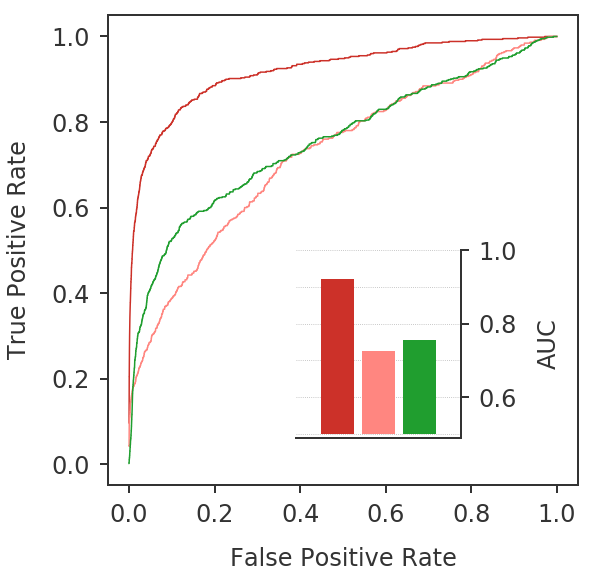

In [51]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111, aspect='equal')

methodcolors = {'rr_sb0.05':  '#cc3129ff',
                'jpa': '#ff8680ff',
                'matrixeqtl': '#209E2FFF',
                'matrixeqtl_fdr': '#1fcc80ff'}

methodlabels = {'rr_sb0.05': 'RevReg',
                'jpa': 'JPA',
                'matrixeqtl': 'MatrixEQTL'}


auclist = list()
for method in methods:
    outfile = os.path.join(srcdir, simdir, 'rocdata/{:s}_{:s}.txt'.format(method, whichplot))
    roc = np.loadtxt(outfile, skiprows=1)
    auc = integrate.simps(roc[:, 1], roc[:, 0])
    auclist.append(auc)
    zoomplot(ax1, roc[:, 0], roc[:, 1], 
             methodlabels[method], zoom = 1, yerr = roc[:, 2], color = methodcolors[method])

plt.tight_layout()

# Inset of AUC
iax = add_vert(fig, ax1, 0.35, 0.4, 0.4, 0.1)
ymax = 1.0
yshift = 0.5
ymajorticks = [0.6, 0.8, 1.0]
yminorticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
yerr = [0 for x in methods]
mcolors = [methodcolors[x] for x in methods]
ecolors = ['#333333' for x in methods]
showyaxis = True
showxlabel = False
showerror = False

single_barplot(iax, auclist, ymax, yerr, mcolors, ecolors, ymajorticks, yminorticks, yshift,
                   "", "AUC", showyaxis, showxlabel, showerror)


ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
plt.savefig('../plots/fpr_tpr_150tf_mean04_gtex_ms_correlation.png', bbox_inches='tight')
plt.show()